# Limpieza y Preparación de Datos para Sistema de Recomendación de Canciones

En este notebook vamos a:
1. Cargar los datos del archivo ARFF
2. Realizar limpieza básica
3. Normalizar los datos
4. Aplicar K-means para reducir el espacio de búsqueda
5. Guardar los datos procesados

In [1]:
# Instalar librería necesaria
!pip install liac-arff

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import arff

In [3]:
# Cargar los datos del archivo ARFF
with open('spotify.arff', 'r') as file:
    data = arff.load(file)

# Convertir a DataFrame
column_names = [attr[0] for attr in data['attributes']]
df = pd.DataFrame(data['data'], columns=column_names)

print("Forma del dataset:", df.shape)
df.head()

Forma del dataset: (170653, 12)


,year,acousticness,artists,danceability,duration_ms,instrumentalness,liveness,loudness,name,popularity,speechiness,tempo
0,1921.0,0.982,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,831667.0,0.878000,0.665,-20.096,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4.0,0.0366,80.954
1,1921.0,0.732,Dennis Day,0.819,180533.0,0.000000,0.160,-12.441,Clancy Lowered the Boom,5.0,0.4150,60.936
2,1921.0,0.961,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062.0,0.913000,0.101,-14.850,Gati Bali,5.0,0.0339,110.339
3,1921.0,0.967,Frank Parker,0.275,210000.0,0.000028,0.381,-9.316,Danny Boy,3.0,0.0354,100.109
4,1921.0,0.957,Phil Regan,0.418,166693.0,0.000002,0.229,-10.096,When Irish Eyes Are Smiling,2.0,0.0380,101.665


## 1. Análisis Exploratorio de Datos

In [4]:
# Información básica del dataset
print("\nInformación del dataset:")
df.info()

print("\nEstadísticas descriptivas:")
df.describe()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              170653 non-null  float64
 1   acousticness      170653 non-null  float64
 2   artists           170653 non-null  object 
 3   danceability      170653 non-null  float64
 4   duration_ms       170653 non-null  float64
 5   instrumentalness  170653 non-null  float64
 6   liveness          170653 non-null  float64
 7   loudness          170653 non-null  float64
 8   name              170652 non-null  object 
 9   popularity        170653 non-null  float64
 10  speechiness       170653 non-null  float64
 11  tempo             170653 non-null  float64
dtypes: float64(10), object(2)
memory usage: 15.6+ MB

Estadísticas descriptivas:


,year,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,1976.787241,0.502115,0.537396,2.309483e+05,0.167010,0.205839,-11.467990,31.431794,0.098393,116.861590
std,25.917853,0.376032,0.176138,1.261184e+05,0.313475,0.174805,5.697943,21.826615,0.162740,30.708533
min,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000
25%,1956.000000,0.102000,0.415000,1.698270e+05,0.000000,0.098800,-14.615000,11.000000,0.034900,93.421000
50%,1977.000000,0.516000,0.548000,2.074670e+05,0.000216,0.136000,-10.580000,33.000000,0.045000,114.729000
75%,1999.000000,0.893000,0.668000,2.624000e+05,0.102000,0.261000,-7.183000,48.000000,0.075600,135.537000
max,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,3.855000,100.000000,0.970000,243.507000


## 2. Limpieza de Datos

In [5]:
# Verificar valores nulos
print("Valores nulos por columna:")
df.isnull().sum()

Valores nulos por columna:


year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
instrumentalness    0
liveness            0
loudness            0
name                1
popularity          0
speechiness         0
tempo               0
dtype: int64

In [6]:
# Eliminar duplicados si los hay
df = df.drop_duplicates()
print("Forma del dataset después de eliminar duplicados:", df.shape)

Forma del dataset después de eliminar duplicados: (170088, 12)


## 3. Normalización de Datos

In [7]:
# Guardar columnas originales antes de normalizar
original_columns = {
    'year': 'year_original',
    'popularity': 'popularity_original',
    'duration_ms': 'duration_ms_original',
    'loudness': 'loudness_original',
    'tempo': 'tempo_original'
}

for col, original_name in original_columns.items():
    if col in df.columns:
        df[original_name] = df[col].copy()

In [12]:
# Seleccionar columnas numéricas para normalizar
numeric_cols = ['acousticness', 'danceability', 'duration_ms', 
                'instrumentalness', 'liveness', 'loudness', 
                'popularity', 'speechiness', 'tempo']
print("Columnas numéricas:", numeric_cols)

# Normalizar datos
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Verificar normalización
df[numeric_cols].describe()

Columnas numéricas: ['acousticness', 'danceability', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo']


,acousticness,danceability,duration_ms,instrumentalness,liveness,loudness,popularity,speechiness,tempo
count,170088.000000,170088.000000,170088.000000,170088.000000,170088.000000,170088.000000,170088.000000,170088.000000,170088.000000
mean,0.502927,0.544362,0.041839,0.165713,0.205904,0.760393,0.315252,0.101567,0.480045
std,0.377235,0.178155,0.023335,0.312317,0.174872,0.088921,0.217893,0.167995,0.126065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.101406,0.421053,0.030534,0.000000,0.098700,0.711268,0.120000,0.035979,0.383878
50%,0.516064,0.554656,0.037490,0.000210,0.136000,0.774192,0.340000,0.046392,0.471329
75%,0.894578,0.677126,0.047656,0.097925,0.261000,0.827234,0.480000,0.078041,0.556715
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Aplicar K-means

In [14]:
# Aplicar K-means
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[numeric_cols])

# Verificar distribución de clusters
print("Distribución de clusters:")
df['cluster'].value_counts().sort_index()

c:\Users\roica\miniconda3\envs\default\Lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\roica\miniconda3\envs\default\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\roica\miniconda3\envs\default\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\roica\miniconda3\envs\default\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\roica\miniconda3\envs\default\Lib\sub

Distribución de clusters:


cluster
0     2340
1     2398
2     2092
3     1192
4     1021
      ... 
95     563
96    1920
97    1387
98     609
99    1337
Name: count, Length: 100, dtype: int64

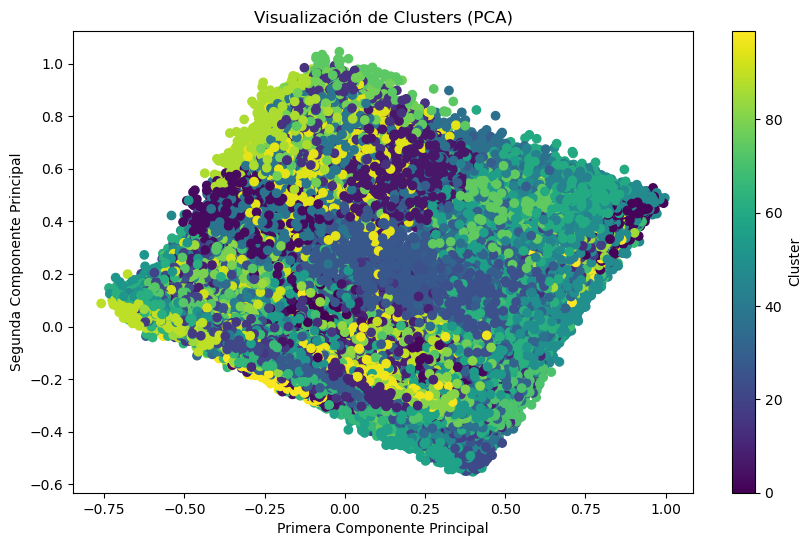

In [15]:
# Visualizar clusters (usando PCA para reducir a 2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[numeric_cols])

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Visualización de Clusters (PCA)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(label='Cluster')
plt.show()

## 5. Guardar Datos Procesados

In [16]:
# Guardar datos procesados
df.to_csv('datos_procesados.csv', index=False)
print("Datos guardados en 'datos_procesados.csv'")

Datos guardados en 'datos_procesados.csv'


In [17]:
df.head()

,year,acousticness,artists,danceability,duration_ms,instrumentalness,liveness,loudness,name,popularity,speechiness,tempo,year_original,popularity_original,duration_ms_original,loudness_original,tempo_original,cluster
0,1921.0,0.985944,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.282389,0.153112,0.878000,0.665,0.624916,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",0.04,0.037732,0.332450,1921.0,4.0,831667.0,-20.096,80.954,68
1,1921.0,0.734940,Dennis Day,0.828947,0.032496,0.000000,0.160,0.744797,Clancy Lowered the Boom,0.05,0.427835,0.250243,1921.0,5.0,180533.0,-12.441,60.936,45
2,1921.0,0.964859,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.331984,0.091685,0.913000,0.101,0.707071,Gati Bali,0.05,0.034948,0.453125,1921.0,5.0,500062.0,-14.850,110.339,1
3,1921.0,0.970884,Frank Parker,0.278340,0.037954,0.000028,0.381,0.793736,Danny Boy,0.03,0.036495,0.411113,1921.0,3.0,210000.0,-9.316,100.109,11
4,1921.0,0.960843,Phil Regan,0.423077,0.029932,0.000002,0.229,0.781521,When Irish Eyes Are Smiling,0.02,0.039175,0.417503,1921.0,2.0,166693.0,-10.096,101.665,61
